In [1]:
import pandas as pd
# import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime
import numpy as np

In [2]:
# set random seed to have reproducible results
# sklearn uses numpy random seed
np.random.seed(42)

In [3]:
df_historical_data = pd.read_csv('datasets/doordash/historical_data.csv')
df_historical_data.head(2)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0


In [4]:
df_historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [5]:
df_historical_data['created_at'] = pd.to_datetime(df_historical_data['created_at'])
df_historical_data['actual_delivery_time'] = pd.to_datetime(df_historical_data['actual_delivery_time'])
df_historical_data['actual_total_delivery_duration'] = (df_historical_data['actual_delivery_time'] - df_historical_data['created_at']).dt.total_seconds()
df_historical_data.head(2)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0


In [6]:
df_historical_data['busy_dashers_ratio'] = df_historical_data['total_busy_dashers'] / df_historical_data['total_onshift_dashers']
df_historical_data['estimated_non_prep_duration'] = df_historical_data['estimated_order_place_duration'] + df_historical_data['estimated_store_to_consumer_driving_duration']

In [7]:
print(f"nunique: \n{df_historical_data[['market_id', 'store_id', 'order_protocol']].nunique()}")

nunique: 
market_id            6
store_id          6743
order_protocol       7
dtype: int64


In [8]:
order_protocol_dummies = pd.get_dummies(df_historical_data['order_protocol'], prefix='order_protocol').astype(int)
order_protocol_dummies.head(2)

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0


In [9]:
market_id_dummies = pd.get_dummies(df_historical_data['market_id'], prefix='market_id').astype(int)
market_id_dummies.head(2)

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0


In [10]:
store_id_unique = df_historical_data['store_id'].unique().tolist()
store_id_and_category = {store_id: df_historical_data[df_historical_data['store_id'] == store_id]['store_primary_category'].mode() 
                         for store_id in store_id_unique}

def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# Ensure the 'nan_free_store_primary_category' column is created before using it
df_historical_data['nan_free_store_primary_category'] = df_historical_data['store_id'].apply(fill)

In [11]:
store_primary_category_dummies = pd.get_dummies(df_historical_data['nan_free_store_primary_category'], prefix='category').astype(int)
print(df_historical_data['nan_free_store_primary_category'].nunique())
store_primary_category_dummies.head(2)

74


,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
train_df = df_historical_data.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time', 'nan_free_store_primary_category', 'actual_delivery_time'])
# train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.head(2)

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0


In [13]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
train_df.head(2)

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,...,0,0,0,0,0,0,0,0,0,0


In [14]:
train_df.describe()

/usr/local/lib/python3.11/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
train_df['busy_dashers_ratio'].describe()

/usr/local/lib/python3.11/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [16]:
# check infinity values with numpy isinfinite() function
np.where(np.any(~np.isfinite(train_df), axis=0) == True)

(array([ 0,  6,  7,  8, 10, 11, 12, 13]),)

In [17]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all nans
train_df.dropna(inplace=True)
train_df.shape

(176166, 101)

In [18]:
# confirm there is not any remaining nans
train_df.isna().sum().sum()

np.int64(0)

<Axes: >

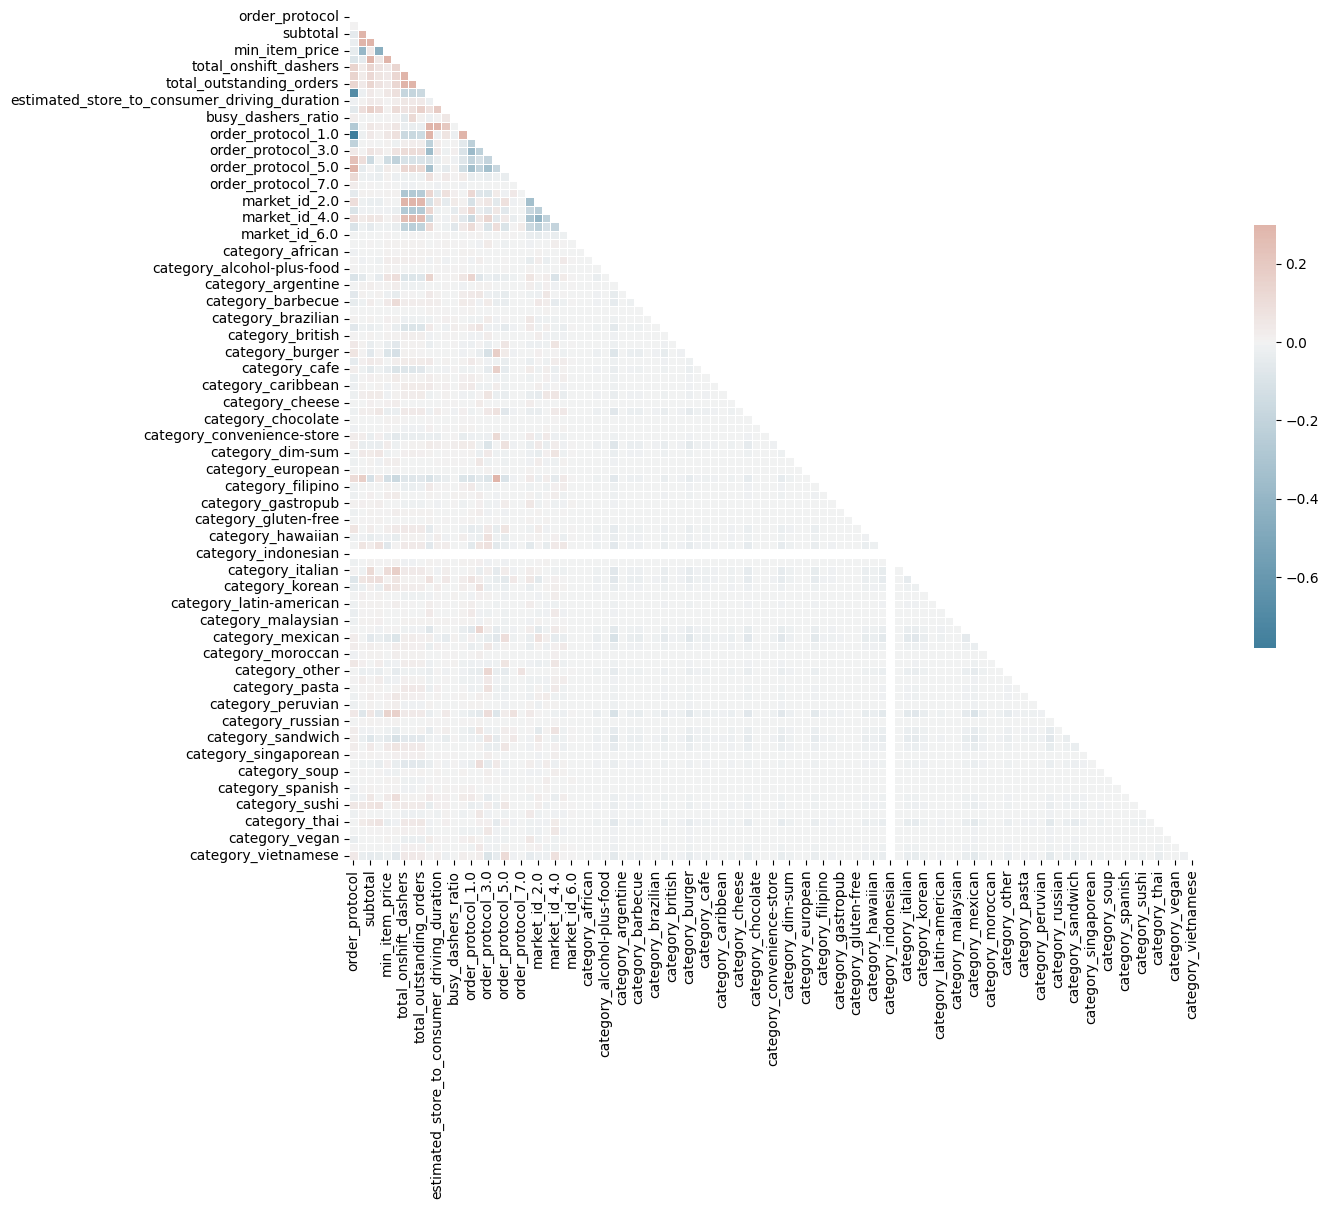

In [19]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 11))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [20]:
train_df.category_indonesian.describe()

count    176166.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [21]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers                0.941755
                                              total_outstanding_orders          0.934653
total_busy_dashers                            total_outstanding_orders          0.931312
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration       0.923067
estimated_order_place_duration                order_protocol_1.0                0.900654
order_protocol                                order_protocol_1.0                0.780826
                                              order_protocol_5.0                0.768999
total_items                                   num_distinct_items                0.757858
order_protocol                                estimated_order_place_duration    0.687007
subtotal                                      num_distinct_items                0.682964
total_items                                   subtotal                          0.55

In [23]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = df_historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat order_protocol_dummies
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)

# drop high correlated features
train_df = train_df.drop(columns = ["total_onshift_dashers", "total_busy_dashers", "category_indonesian", "estimated_non_prep_duration"])
# align dtype over dataset
train_df = train_df.astype('float32')
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
train_df.shape

(177070, 90)

In [25]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

In [26]:
# new features
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0                0.897645
min_item_price                  avg_price_per_item                0.860580
max_item_price                  avg_price_per_item                0.770382
min_item_price                  max_item_price                    0.541241
order_protocol_4.0              category_fast                     0.489946
total_items                     percent_distinct_item_of_total    0.445751
                                min_item_price                    0.389277
order_protocol_1.0              order_protocol_3.0                0.373581
estimated_order_place_duration  order_protocol_3.0                0.364170
order_protocol_1.0              order_protocol_5.0                0.342345
estimated_order_place_duration  order_protocol_5.0                0.333291
order_protocol_3.0              order_protocol_5.0                0.332533
total_items                     avg_price_per_item                0.310759

In [27]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration                order_protocol_1.0                0.897645
order_protocol_4.0                            category_fast                     0.489946
total_items                                   percent_distinct_item_of_total    0.445751
order_protocol_1.0                            order_protocol_3.0                0.373581
estimated_order_place_duration                order_protocol_3.0                0.364170
order_protocol_1.0                            order_protocol_5.0                0.342345
total_items                                   price_range_of_items              0.333304
estimated_order_place_duration                order_protocol_5.0                0.333291
order_protocol_3.0                            order_protocol_5.0                0.332533
total_items                                   avg_price_per_item                0.310759
order_protocol_1.0                            order_protocol_2.0                0.22

In [28]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [29]:
# apply VIF computation to all columns
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
# drop features that have over 20 VIF score
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000864
1,category_chocolate,1.000903
2,category_belgian,1.001622
3,category_russian,1.007996
4,category_african,1.008277
...,...,...
83,order_protocol_5.0,29.586838
84,percent_distinct_item_of_total,32.148266
85,order_protocol_3.0,33.681747
86,order_protocol_1.0,45.019928


In [30]:
# drop with highest vif score until all vif scores are under 20
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove estimated_order_place_duration
I will remove order_protocol_1.0
I will remove percent_distinct_item_of_total


,feature,VIF
0,category_belgian,1.000192
1,category_alcohol-plus-food,1.000226
2,category_chocolate,1.000243
3,category_gluten-free,1.001221
4,category_russian,1.001502
...,...,...
80,category_american,3.148787
81,category_pizza,3.271753
82,avg_price_per_item,5.967503
83,busy_dashers_ratio,6.363307


In [69]:
train_df = train_df.astype('float32')
train_df.head(2)

TypeError: Cannot cast DatetimeArray to dtype float32

In [111]:
# Which columns have null values?
np.where(np.any(~np.isfinite(train_df), axis=0) == True)

(array([ 0,  6,  7,  8, 10, 11, 12, 13]),)

In [112]:
# looking for problems with variables
train_df.describe()

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,estimated_non_prep_duration,busy_dashers_ratio,total_delivery_duration_seconds
count,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,196902.000000,177551.000000,1.974210e+05
mean,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935,853.939183,0.949777,2.908257e+03
std,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902,235.112835,0.406184,1.922961e+04
min,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,153.000000,-13.000000,1.010000e+02
25%,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,683.000000,0.826667,2.104000e+03
50%,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,850.000000,0.962264,2.660000e+03
75%,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,1017.000000,1.000000,3.381000e+03
max,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,3222.000000,31.000000,8.516859e+06


In [63]:
train_df['busy_dashers_ratio'].describe()

/usr/local/lib/python3.11/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [65]:
np.where(np.any(~np.isfinite(train_df), axis=0) == True)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''